<a href="https://colab.research.google.com/github/elka97/pythonLibrariesCourse/blob/main/kursovaya_ML2_xgb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Подключение библиотек и скриптов**

In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 66kB/s 


In [2]:
!pip install category_encoders

     |████████████████████████████████| 81kB 7.5MB/s 


In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

#  pre-processing pipelines
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))    

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def extract_metadata(df_columns, ind_prefix):    
    columns = [el for el in df_columns if (el.startswith(ind_prefix.capitalize()) or el.startswith(ind_prefix) or str(el).lower().startswith(ind_prefix.lower()))]
    if len(columns) == 0:
        print(f"No {ind_prefix} found.")
    return columns
    
def drop_extra_cols(d, droplist): 
  print(f"Dropping columns {droplist}") 
  df1 = d.drop(columns=droplist, axis=1, errors='ignore')
  return df1

def get_X_y(data):
  X = data.drop(columns=[TARGET_NAME], axis=1, errors='ignore')
  y = data[TARGET_NAME]
  return X, y

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def category_target_plot(var):
  plt.figure(figsize=(10, 8))
  sns.countplot(x=var, hue=TARGET_NAME, data=train_df)
  plt.title(var+' grouped by target variable')
  plt.legend(title='Target', loc='upper right')
  plt.show()

In [7]:
def to_digits(s):  
   return ''.join(i for i in s if i.isdigit())

In [8]:
def load_data():
  train_df = pd.read_csv(TRAIN_DATASET_PATH)
  test_df = pd.read_csv(TEST_DATASET_PATH)
  train_df = reduce_mem_usage(train_df)
  test_df = reduce_mem_usage(test_df)
  print(train_df.shape, test_df.shape )
  return train_df, test_df

In [9]:
import warnings
warnings.simplefilter('ignore')

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [10]:
def display_stats(df, var):
  _mean = round(df[var].mean(), 2)
  _median = df[var].median()
  _mode = df[var].mode()[0]
  _mean, _median, df[var].mode()
  y_length = len(df[var])
  print(f"mean: {_mean}\nmedian: {_median}\nmode: {_mode}")
  plt.figure(figsize = (8, 4))
  sns.distplot(df[var], bins=50)
  y = np.linspace(0, 0.000005, 10)
  plt.plot([_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
  plt.plot([_median] * 10, y, label='median', linestyle='--', linewidth=4)
  plt.plot([_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)
  plt.title(f"Distribution of {var}")
  plt.legend()
  plt.show()

In [11]:
def hst(df, var):
    plt.figure(figsize=(20,8))
    ax1 = plt.subplot(121)
    ax1.set_xlabel(var)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{var} distribution')
    df[var].hist()
    plt.subplot(122)
    probplot(df[var],dist='norm',plot=plt)
    plt.show()

**Пути к директориям и файлам**

In [12]:
# input
# TRAIN_FULL_PATH = '../training_project_train_full.csv'
# TRAIN_PART_PATH = '../training_project_train_part_b.csv'
# TEST_PART_PATH = '../training_project_test_part.csv'
# output
# MODEL_FILE_PATH = '../model.pkl'

#  my google disk
DATASET_PATH = "/gdrive/My Drive/datasets/"

TRAIN_DATASET_PATH = DATASET_PATH +"kusrovaya_Kamilya/course_project_train.csv"
TEST_DATASET_PATH = DATASET_PATH +"kusrovaya_Kamilya/course_project_test.csv"
SUBMIT_DATASET_FILE = DATASET_PATH +"kusrovaya_Kamilya/sample_submission.csv"
SUBMIT_DATASET_PATH = DATASET_PATH +"kusrovaya_Kamilya/"

# output
MODEL_FILE_PATH = DATASET_PATH +"kusrovaya_Kamilya/models/"

In [13]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Constants

In [14]:
TARGET_NAME = 'Credit Default'
CATEGORY_DTYPE = 'int8'

**Обзор данных**

**Описание датасета**

*   Home Ownership - домовладение
*   Annual Income - годовой доход
*   Years in current job - количество лет на текущем месте работы
*   Tax Liens - налоговые обременения
*   Number of Open Accounts - количество открытых счетов
*   Years of Credit History - количество лет кредитной истории
*   Maximum Open Credit - наибольший открытый кредит
*   Number of Credit Problems - количество проблем с кредитом
*   Months since last delinquent - количество месяцев с последней просрочки платежа
*   Bankruptcies - банкротства
*   Purpose - цель кредита
*   Term - срок кредита
*   Current Loan Amount - текущая сумма кредита
*   Current Credit Balance - текущий кредитный баланс
*   Monthly Debt - ежемесячный долг
*   Credit Score - кредитный рейтинг
*   Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [15]:
train_df, test_df = load_data()

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%
(7500, 17) (2500, 16)


**EDA**

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [17]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [18]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [19]:
train_df.sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4729,Home Mortgage,1603372.0,10+ years,0.0,17.0,19.900000,799568.0,0.0,20.0,0.0,debt consolidation,Short Term,100000000.0,422617.0,27658.0,729.0,0
3859,Rent,1735061.0,10+ years,0.0,12.0,23.400000,395494.0,1.0,63.0,1.0,debt consolidation,Long Term,772706.0,151316.0,28050.0,599.0,1
270,Own Home,NaN,10+ years,0.0,11.0,14.000000,558250.0,0.0,NaN,0.0,debt consolidation,Short Term,129206.0,24586.0,930.0,NaN,0
1913,Home Mortgage,NaN,10+ years,0.0,6.0,31.700001,404338.0,1.0,NaN,1.0,debt consolidation,Short Term,441034.0,106856.0,8250.0,NaN,0
3428,Home Mortgage,779418.0,NaN,0.0,8.0,34.799999,242968.0,1.0,55.0,1.0,debt consolidation,Short Term,142626.0,114361.0,11107.0,668.0,0


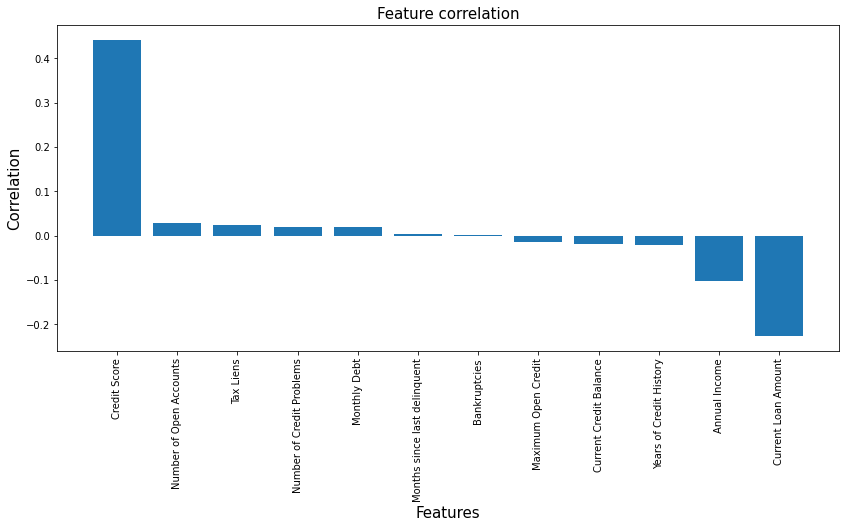

In [20]:
correlation = train_df.corrwith(train_df[TARGET_NAME]).sort_values(ascending=False)
correlation.drop(TARGET_NAME, inplace=True)
plt.figure(figsize = (14, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

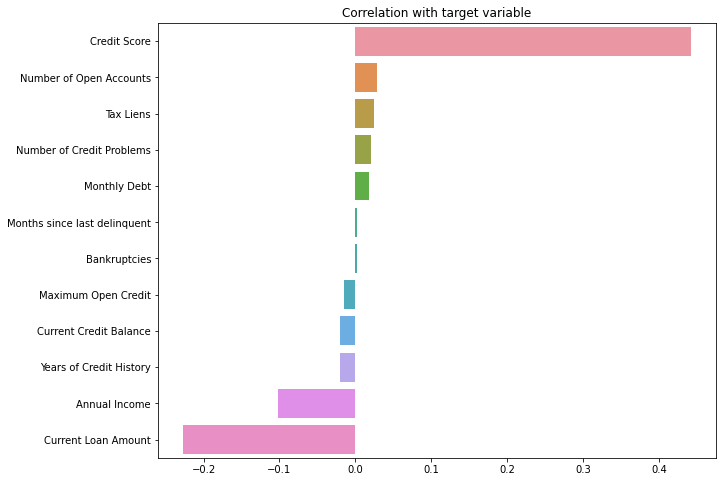

In [21]:
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
cols = list(train_df.columns)
cols.remove(TARGET_NAME)
corr_with_target = train_df[cols + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0538fec450>,
      dtype=object)

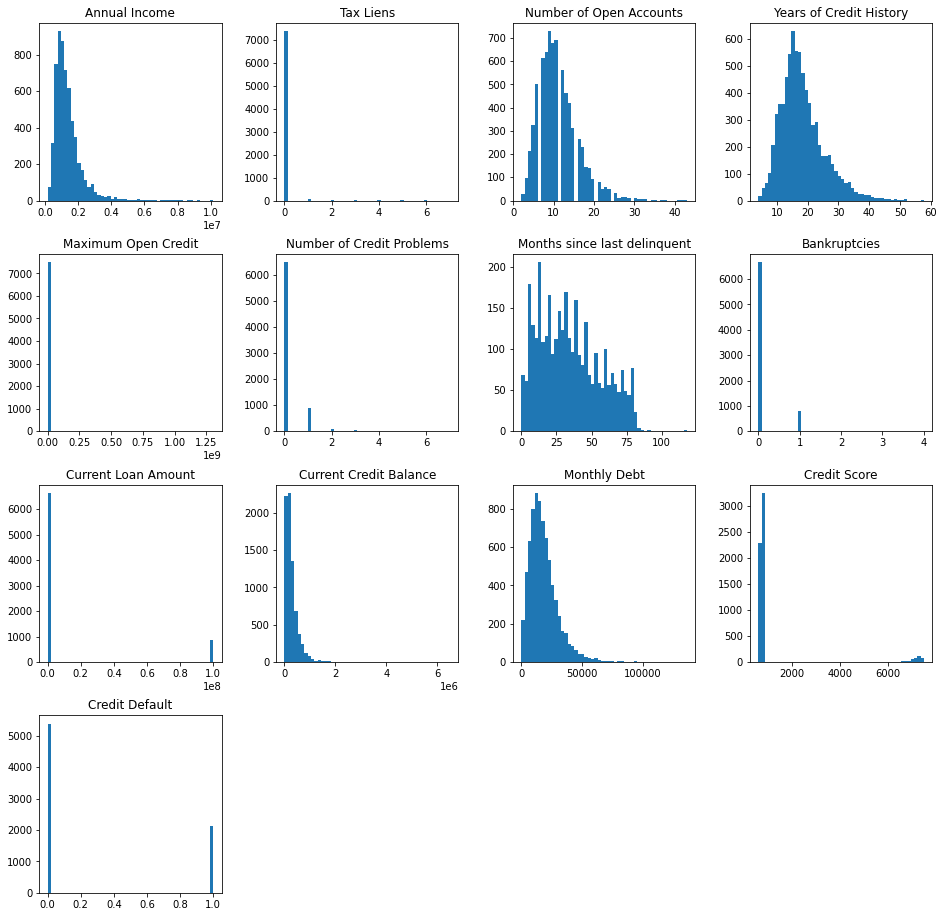

In [22]:
train_df.hist(figsize=(16,16), bins=50, grid=False)

**EDA** **Numeric features**

**2. Annual Income**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f053833b790>,
 count    5.943000e+03
 mean     1.366390e+06
 std      8.453384e+05
 min      1.645970e+05
 25%      8.443410e+05
 50%      1.168386e+06
 75%      1.640137e+06
 max      1.014934e+07
 Name: Annual Income, dtype: float64,
 1557,
 1161660.0    4
 1058376.0    4
 1338113.0    4
 1043651.0    4
 969475.0     4
             ..
 1539152.0    1
 1177411.0    1
 266000.0     1
 785954.0     1
 2083825.0    1
 Name: Annual Income, Length: 5478, dtype: int64)

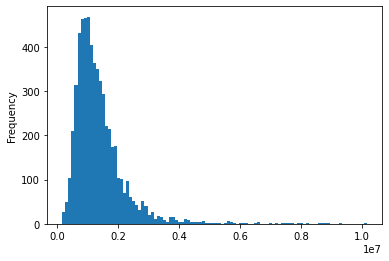

In [23]:
var = 'Annual Income'
train_df[var].plot.hist(bins=100), train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts().sort_values(ascending=False)

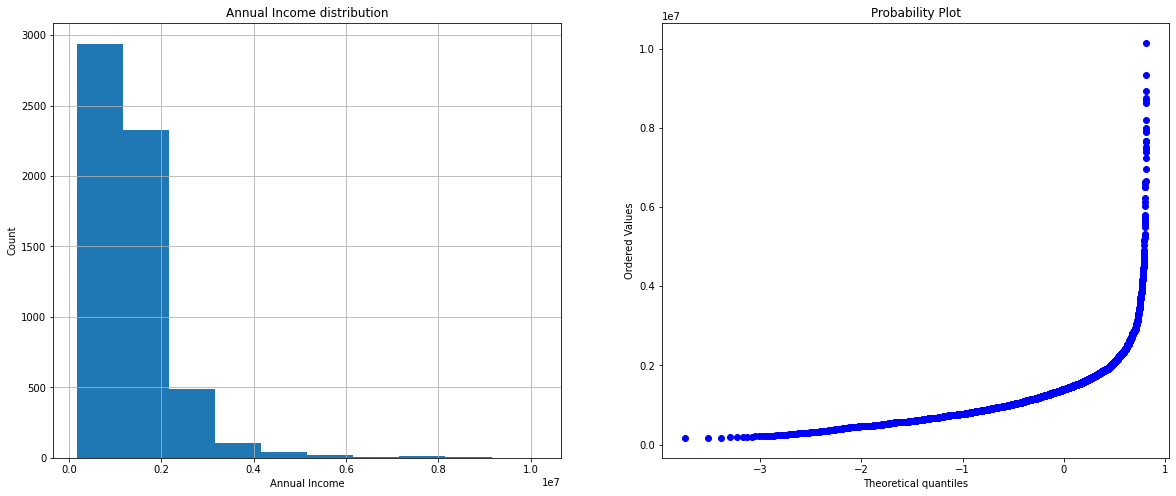

In [24]:
hst(train_df, var)

mean: 1366389.75
median: 1168386.0
mode: 969475.0


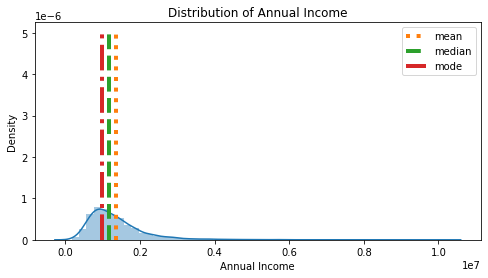

In [25]:
display_stats(train_df, var)

In [26]:
train_df[var+"cliped"] = np.clip(train_df[var], a_max=5000000, a_min=train_df[var].min())
# to remove outliers at right

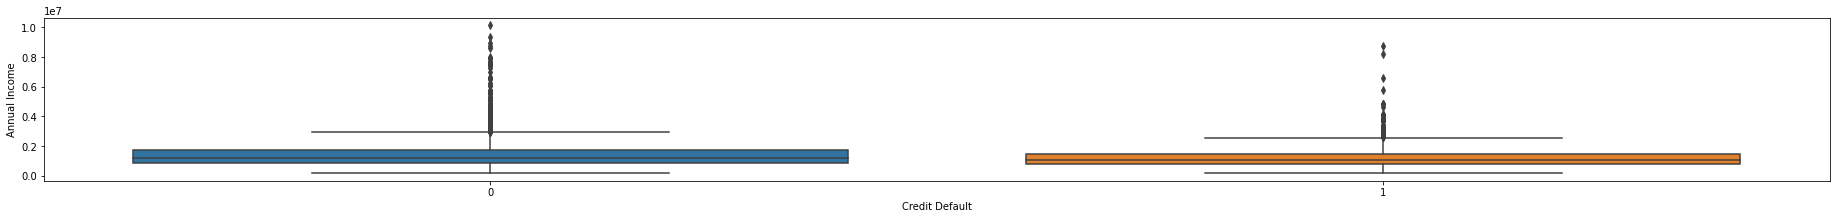

In [27]:
data = pd.concat([train_df[TARGET_NAME], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(32, 3))
fig = sns.boxplot(x=TARGET_NAME, y=var, data=data)

**12.  Current Loan Amount**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f05380f8350>,
 count         7500.0
 mean      11873135.0
 std       31926302.0
 min          11242.0
 25%         180169.0
 50%         309573.0
 75%         519882.0
 max      100000000.0
 Name: Current Loan Amount, dtype: float64,
 0,
 100000000.0    870
 89298.0          6
 218064.0         6
 216106.0         5
 270226.0         5
               ... 
 200640.0         1
 290642.0         1
 367334.0         1
 186846.0         1
 264616.0         1
 Name: Current Loan Amount, Length: 5386, dtype: int64)

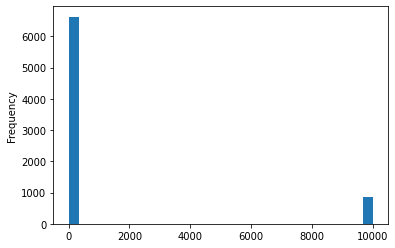

In [50]:
var = 'Current Loan Amount'
ukrupn = round(train_df[var]/10000, 0)
ukrupn.plot.hist(bins=30), train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts().sort_values(ascending=False)
# 100000000.0    870 looks like cutted

mean: 11873135.0
median: 309573.0
mode: 100000000.0


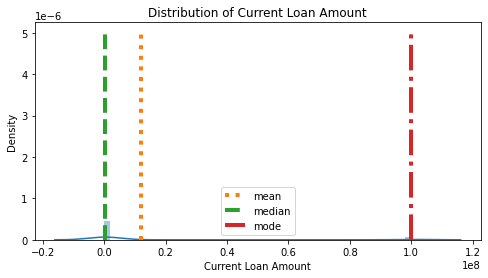

In [29]:
display_stats(train_df, var)

**6. Maximum Open Credit**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0537af2ad0>,
 count    7.500000e+03
 mean     9.451526e+05
 std      1.602614e+07
 min      0.000000e+00
 25%      2.792295e+05
 50%      4.781590e+05
 75%      7.935015e+05
 max      1.304726e+09
 Name: Maximum Open Credit, dtype: float64,
 0,
 0.0          65
 319110.0      5
 334796.0      3
 607046.0      3
 294030.0      3
              ..
 534600.0      1
 1026124.0     1
 77066.0       1
 780164.0      1
 350768.0      1
 Name: Maximum Open Credit, Length: 6963, dtype: int64)

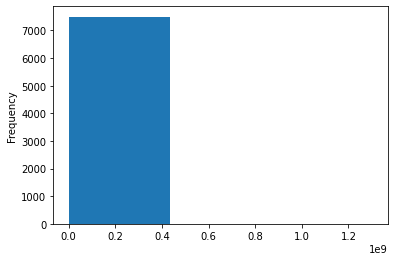

In [30]:
var = 'Maximum Open Credit'
train_df[var].plot.hist(bins=3), train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts()

**15. Credit Score**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0538834f10>,
 count    5943.000000
 mean     1151.087524
 std      1604.447510
 min       585.000000
 25%       711.000000
 50%       731.000000
 75%       743.000000
 max      7510.000000
 Name: Credit Score, dtype: float64,
 1557)

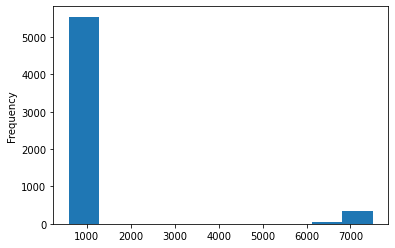

In [31]:
var = 'Credit Score'
train_df[var].plot.hist(), train_df[var].describe(), train_df[var].isnull().sum()

In [32]:
train_df.loc[train_df[var]>850]
# For both the VantageScore and base FICO® score models, the lowest score is 300 and the highest credit score is 850. But even if you have pretty good credit habits, don't be surprised if you check your scores and find that you're below 850.
# The best-known range of FICO scores is 300 to 850. Anything above 700 is generally considered to be good. FICO also offers industry-specific FICO scores, such as for credit cards or auto loans, which can range from 250 to 900.

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Incomecliped
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.500000,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1,1408527.0
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.800000,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1,1533566.0
94,Rent,1049294.0,3 years,0.0,5.0,6.100000,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1,1049294.0
96,Rent,757568.0,5 years,0.0,13.0,11.400000,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1,757568.0
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.799999,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1,1039984.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.800000,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1,694868.0
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.900000,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1,2011758.0
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.799999,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1,1432277.0
7460,Rent,769462.0,5 years,0.0,8.0,17.000000,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1,769462.0


mean: 1151.09
median: 731.0
mode: 740.0


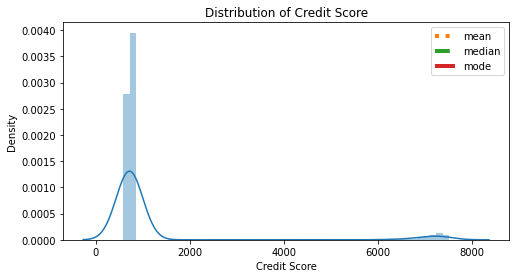

In [33]:
display_stats(train_df, var)

**3. Years in current job**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f053873c810>, count          7129
 unique           11
 top       10+ years
 freq           2332
 Name: Years in current job, dtype: object, 371)

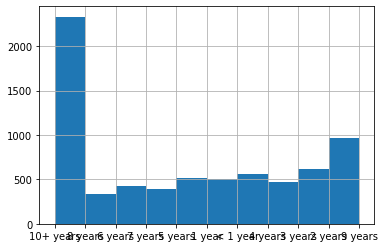

In [34]:
var = 'Years in current job'
train_df[var].hist(), train_df[var].describe(), train_df[var].isnull().sum()

**1. Home Ownership**

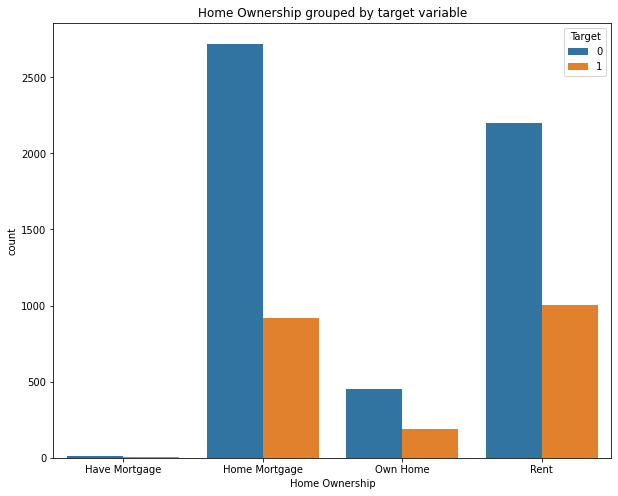

(None, count              7500
 unique                4
 top       Home Mortgage
 freq               3637
 Name: Home Ownership, dtype: object, Home Mortgage    3637
 Rent             3204
 Own Home          647
 Have Mortgage      12
 Name: Home Ownership, dtype: int64, 0)

In [35]:
var = 'Home Ownership'
category_target_plot(var), train_df[var].describe(), train_df[var].value_counts(), train_df[var].isnull().sum()

**4. Tax Liens**

(count    7500.000000
 mean        0.030133
 std         0.271613
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         7.000000
 Name: Tax Liens, dtype: float64, 0, 0.0    7366
 1.0      83
 2.0      30
 3.0      10
 4.0       6
 5.0       2
 6.0       2
 7.0       1
 Name: Tax Liens, dtype: int64)

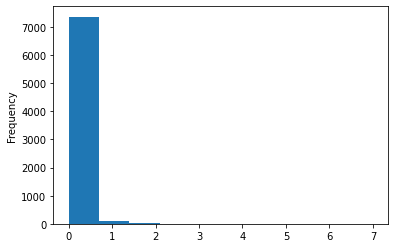

In [36]:
var = 'Tax Liens'
train_df[var].plot.hist(), 
train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts()

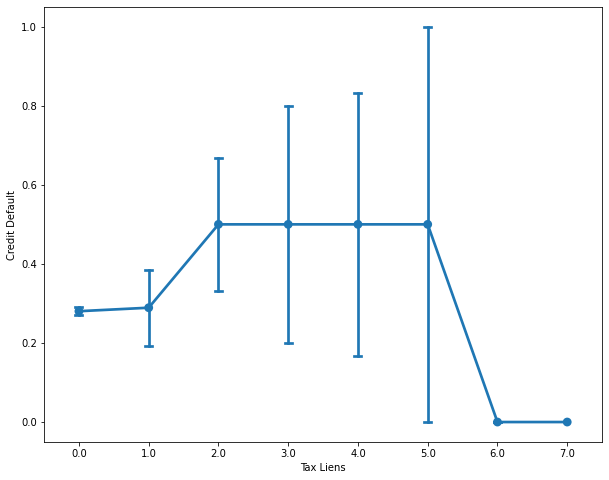

In [37]:
plt.figure(figsize=(10, 8))
sns.pointplot(x=var, y=TARGET_NAME, data=train_df, capsize=.1,)

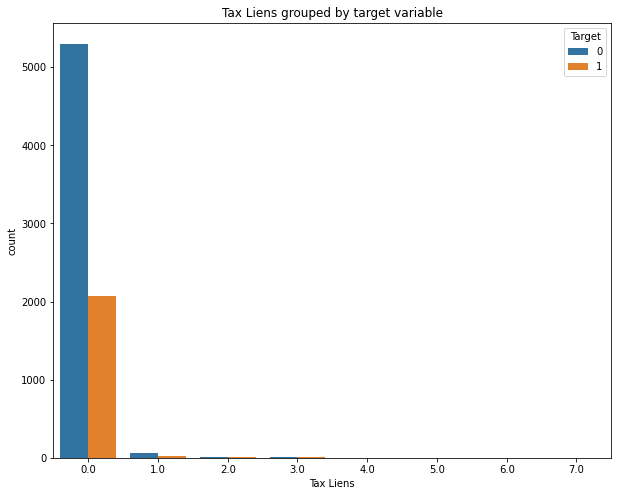

mean: 0.03
median: 0.0
mode: 0.0


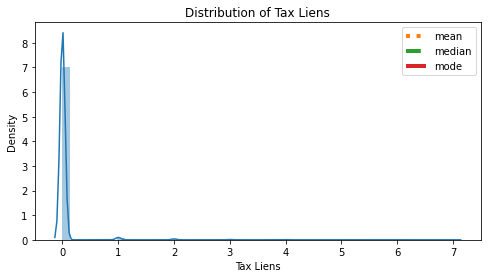

(None, None)

In [39]:
category_target_plot(var), display_stats(train_df, var)

**7.   Number of Credit Problems**

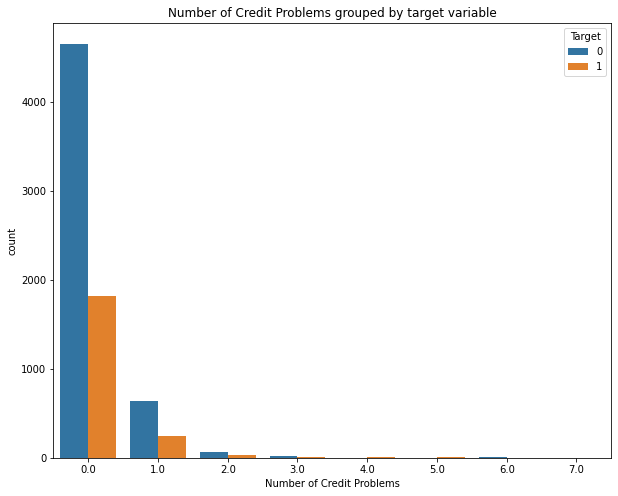

(count    7500.0000
 mean        0.1700
 std         0.4986
 min         0.0000
 25%         0.0000
 50%         0.0000
 75%         0.0000
 max         7.0000
 Name: Number of Credit Problems, dtype: float64, 0, None)

In [40]:
var = 'Number of Credit Problems'
train_df[var].describe(),  train_df[var].isnull().sum(), category_target_plot(var)

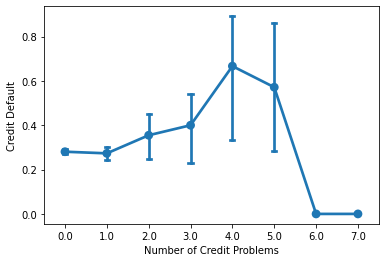

In [41]:
sns.pointplot(x=var, y=TARGET_NAME, data=train_df, capsize=.1,)

**8.   Months since last delinquent**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f05376617d0>,
 count    3419.000000
 mean       34.692600
 std        21.688801
 min         0.000000
 25%        16.000000
 50%        32.000000
 75%        50.000000
 max       118.000000
 Name: Months since last delinquent, dtype: float64,
 4081,
 14.0     76
 29.0     71
 8.0      68
 33.0     68
 13.0     65
          ..
 86.0      1
 92.0      1
 118.0     1
 84.0      1
 91.0      1
 Name: Months since last delinquent, Length: 89, dtype: int64)

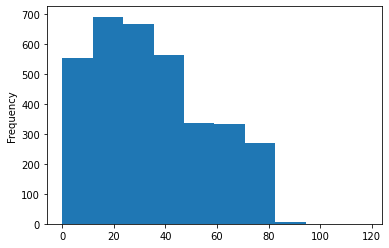

In [42]:
var = 'Months since last delinquent'
train_df[var].plot.hist(), train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts()

mean: 34.69
median: 32.0
mode: 14.0


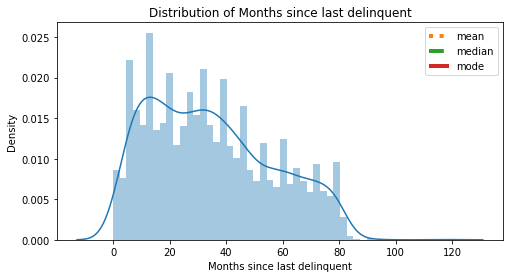

In [43]:
display_stats(train_df, var)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f05374887d0>,
 count    3419.000000
 mean       34.692600
 std        21.688801
 min         0.000000
 25%        16.000000
 50%        32.000000
 75%        50.000000
 max       118.000000
 Name: Months since last delinquent, dtype: float64)

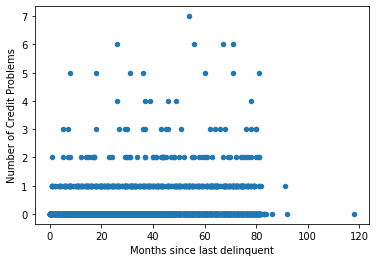

In [44]:
data = pd.concat([train_df['Number of Credit Problems'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='Number of Credit Problems'), train_df[var].describe()

**9. Bankruptcies**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f053757ca90>,
 count    7486.000000
 mean        0.117152
 std         0.347197
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         4.000000
 Name: Bankruptcies, dtype: float64,
 14,
 0.0    6660
 1.0     786
 2.0      31
 3.0       7
 4.0       2
 Name: Bankruptcies, dtype: int64)

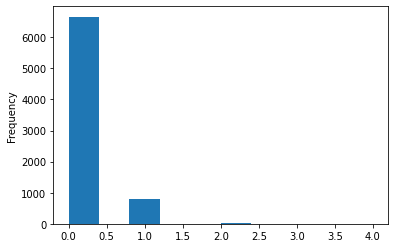

In [45]:
var = 'Bankruptcies'
train_df[var].plot.hist(), train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f053771b150>,
 count    7486.000000
 mean        0.117152
 std         0.347197
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         4.000000
 Name: Bankruptcies, dtype: float64)

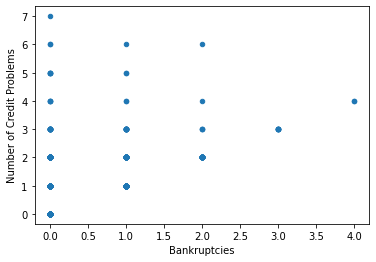

In [46]:
data = pd.concat([train_df['Number of Credit Problems'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='Number of Credit Problems'), train_df[var].describe()

**Purpose**

In [51]:
var = 'Purpose'
train_df[var].describe(), train_df[var].isnull().sum(), train_df[var].value_counts()

(count                   7500
 unique                    15
 top       debt consolidation
 freq                    5944
 Name: Purpose, dtype: object, 0, debt consolidation      5944
 other                    665
 home improvements        412
 business loan            129
 buy a car                 96
 medical bills             71
 major purchase            40
 take a trip               37
 buy house                 34
 small business            26
 wedding                   15
 moving                    11
 educational expenses      10
 vacation                   8
 renewable energy           2
 Name: Purpose, dtype: int64)

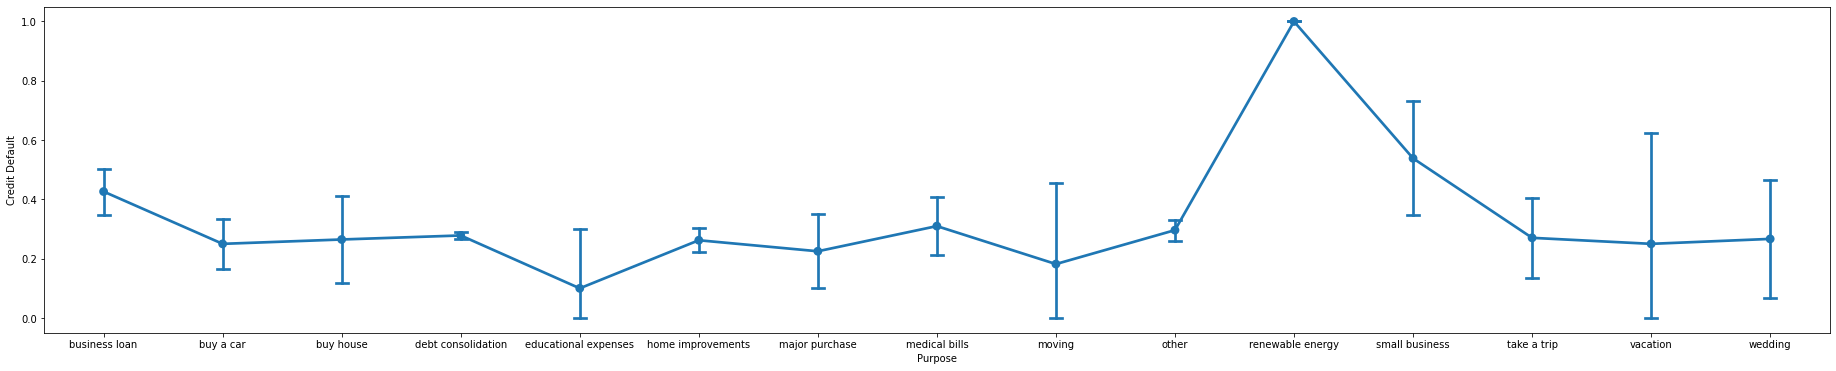

In [52]:
plt.figure(figsize=(32, 6))
sns.pointplot(x=var, y=TARGET_NAME, data=train_df, capsize=.1,)

**Data preprocessing**

In [55]:
import warnings
import sklearn

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [56]:
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import category_encoders as ce

In [57]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyMultiLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

class MyLabelEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelEncoder(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [58]:
train_df, test_df = load_data()
X, y = get_X_y(train_df)
print(f"X.shape: {X.shape} y.shape.shape: {y.shape}") 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, stratify=y, test_size=2500, random_state=21)  
print(f"X_train.shape: {X_train.shape} X_valid.shape: {X_valid.shape} test_df.shape: {test_df.shape}") 

allfeatures = X_train.columns.to_list()
print(allfeatures)

numeric_simple = make_pipeline(RobustScaler(quantile_range=[0.15, 0.85]), SimpleImputer(strategy="median"))
like_cat = make_pipeline(SimpleImputer(strategy="most_frequent"), ce.cat_boost.CatBoostEncoder())
multi_label = make_pipeline(ce.cat_boost.CatBoostEncoder(), SimpleImputer(strategy="most_frequent"))
binarized = make_pipeline(MyLabelBinarizer(), SimpleImputer(strategy="most_frequent"))  
linear_pca = make_pipeline(RobustScaler(quantile_range=[0.15, 0.85]), SimpleImputer(strategy="median"), PCA(random_state=21))
nonlinear_pca = make_pipeline(RobustScaler(quantile_range=[0.15, 0.85]), SimpleImputer(strategy="most_frequent"), KernelPCA(random_state=21, n_jobs=-1) ) 

numeric_simple_cols = ['Annual Income', 'Credit Score', 'Maximum Open Credit'] 
linear_pca_cols = ['Monthly Debt', 'Current Loan Amount', 'Current Credit Balance']
nonlinear_pca_cols= ['Bankruptcies', 'Number of Credit Problems', 'Months since last delinquent']
like_cat_cols = ['Tax Liens', 'Number of Open Accounts', 'Years of Credit History']
multi_label_cols = ['Home Ownership', 'Years in current job', 'Purpose']
binarized_cols = ['Term']

print("all columns", len(allfeatures), (len(numeric_simple_cols)+len(linear_pca_cols)+len(nonlinear_pca_cols)+len(like_cat)+len(multi_label_cols)+len(binarized_cols)))

prerpocess_transform = make_column_transformer(  
    (numeric_simple, numeric_simple_cols),  
    (like_cat, like_cat_cols),  
    (multi_label, multi_label_cols), 
    (binarized, binarized_cols),          
    (linear_pca, linear_pca_cols),
    (nonlinear_pca, nonlinear_pca_cols),
  remainder="passthrough",
  n_jobs=-1,
  verbose=True
    )

X_train = prerpocess_transform.fit_transform(X_train, y_train)
X_valid = prerpocess_transform.transform(X_valid)
test_df = prerpocess_transform.transform(test_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%
(7500, 17) (2500, 16)
X.shape: (7500, 16) y.shape.shape: (7500,)
X_train.shape: (5000, 16) X_valid.shape: (2500, 16) test_df.shape: (2500, 16)
['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
all columns 16 15


In [59]:
X_train[0], X_train[1], X_train[2]

(array([      0.,       0., -220352., ...,      -0.,      -0.,      -0.]),
 array([-1.37183321e+00, -3.21367741e-01,  4.53068000e+05, ...,
        -1.60308822e-09, -1.48021179e-10, -5.95313798e-10]),
 array([ 2.46737194e+00,  1.28547102e-01, -1.14950000e+05, ...,
        -3.23920744e-07, -6.84518852e-07, -5.42854650e-07]))

In [60]:
fet = get_feature_names(prerpocess_transform)
fet

TypeError: ignored

In [61]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5000, 1275), (5000,), (2500, 1275), (2500,))

In [62]:
def class_disbalance(y):
  target_vals=y.value_counts()  
  print(target_vals)
  disbalance = round(target_vals[0]/target_vals[1], 2)  
  class_we = [1, disbalance]
  print(class_we)
  return class_we

class_weights = class_disbalance(y_train)

0    3591
1    1409
Name: Credit Default, dtype: int64
[1, 2.55]


*XGBoost*

In [63]:
ratio = float(np.sum(y == 1)) / np.sum(y==0)
ratio

0.39224057917208094

TRAIN

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3591
           1       1.00      0.38      0.55      1409

    accuracy                           0.82      5000
   macro avg       0.90      0.69      0.72      5000
weighted avg       0.86      0.82      0.79      5000

TEST

              precision    recall  f1-score   support

           0       0.84      0.55      0.66      1796
           1       0.39      0.74      0.51       704

    accuracy                           0.60      2500
   macro avg       0.62      0.64      0.59      2500
weighted avg       0.72      0.60      0.62      2500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               986  810
1               184  520
0.5113077679449362


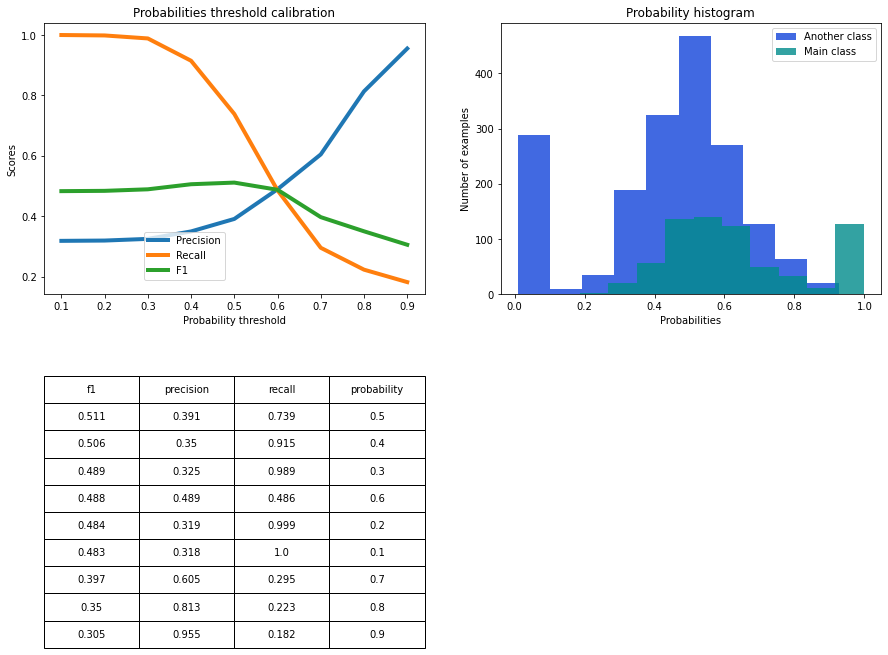

In [64]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                # missing=9999999999,
                # max_depth = 5,
                # n_estimators=2000,
                # learning_rate=0.03, 
                # nthread=4,
                # subsample=1.0,
                # colsample_bytree=0.5,
                # min_child_weight = 3,
                # scale_pos_weight = ratio,
                # reg_alpha=0.03,
                )
                # eval_metric="auc",
model_xgb.fit(X_train, y_train) #, early_stopping_rounds=50, eval_set=[(X_train, y_train), (X_valid, y_valid)])

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_valid)
y_test_pred_probs = model_xgb.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)
print(f1_score(y_valid, y_test_pred))

show_proba_calibration_plots(y_test_pred_probs[:, 1], y_valid)
# 0.5113077679449362

**Сохранение модели**

In [65]:
def save_model(model, mname, threshold=None):
  # if threshold >= 0.70:
  with open(MODEL_FILE_PATH+mname, 'wb') as file:
    pickle.dump(model, file)  

**8. Прогнозирование на тестовом датасете**

In [66]:
def save_submit(model, mname, df):
  submit = pd.read_csv(SUBMIT_DATASET_FILE)
  submit.head()
  predictions = model.predict(test_df)
  predictions
  submit[TARGET_NAME] = predictions
  submit.head() 
  submit.to_csv(SUBMIT_DATASET_PATH+mname+'_submit.csv', index=False)

In [67]:
save_submit(model_xgb, "xgb19052021_2", test_df)
save_model(model_xgb, "xgb19052021_2") #0.5113077679449362